In [1]:
import cv2
import numpy as np
import torch
from collections import OrderedDict
from torch.nn import functional as F
from torchvision.transforms import functional as TF
from utils.factory import model_factory, dataset_factory
from utils.data_format import print_metric
# from utils.onehot_convert import *
from utils.metrics import *
import matplotlib.pyplot as plt
from pytorch_grad_cam.grad_cam import GradCAM
# from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

d:\ROOT\anaconda\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SemanticSegmentationTarget:
    """ Gets a binary spatial mask and a category,
        And return the sum of the category scores,
        of the pixels in the mask. """

    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        # print("===>",model_output.size(), self.mask.size())
        data = (model_output * self.mask).sum()
        print(data)
        return data

In [2]:
def get_model(model_path, model_name, class_num:int=1):
    model = model_factory(model_name)(1, class_num)
    state_dict = torch.load(model_path)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v
    model.load_state_dict(new_state_dict)
    model.to(torch.device('cuda:0'))
    return model

In [4]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

tensor(64171.1055, device='cuda:0', grad_fn=<SumBackward0>)


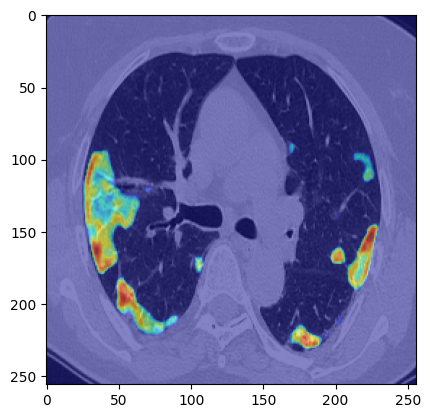

In [30]:
model = get_model("./model.pth", "UNet")
# print(model)
image = np.load("E:\\dataset\\dataset_test\\ct_scans\\radiopaedia_14_85914_0_66.npy")
if np.max(image) > 1.0:
    image = image / 255.0
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.type(torch.FloatTensor)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.unsqueeze(0)

if torch.cuda.is_available():
    model = model.cuda()
    image_tensor = image_tensor.cuda()

model = SegmentationModelOutputWrapper(model)
output = model(image_tensor)
pred = torch.sigmoid(output)
normalized_masks = torch.where(pred >= 0.5, torch.ones_like(
                pred), torch.zeros_like(pred))

sem_classes = [
    'background', 'COVID-19'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}



# 将需要进行CAM的类名写至此处
plaque_category = sem_class_to_idx["COVID-19"]
plaque_mask = normalized_masks[0, :, :, :].detach().cpu().numpy()
plaque_mask_uint8 = 255 * np.uint8(plaque_mask == plaque_category)
plaque_mask_float = np.float32(plaque_mask == plaque_category)



target_layers = [model.model.up4]
targets = [SemanticSegmentationTarget(plaque_category, plaque_mask_float)]
cam = GradCAM(model=model,
                target_layers=target_layers,
                use_cuda=torch.cuda.is_available())
grayscale_cam = cam(input_tensor=image_tensor,
                    targets=targets)[0, :]
img = np.expand_dims(image, axis=-1)
img = np.concatenate((img, img, img), axis=-1)
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

(256, 256)


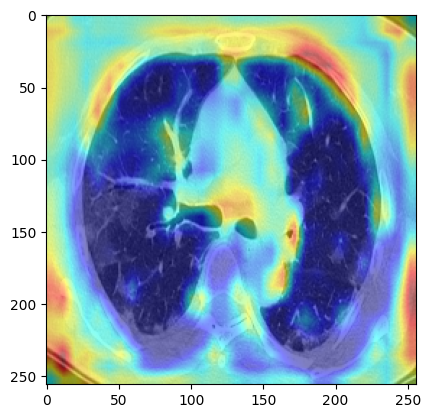

In [16]:
import matplotlib.pyplot as plt

img = np.expand_dims(image, axis=-1)
img = np.concatenate((img, img, img), axis=-1)
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

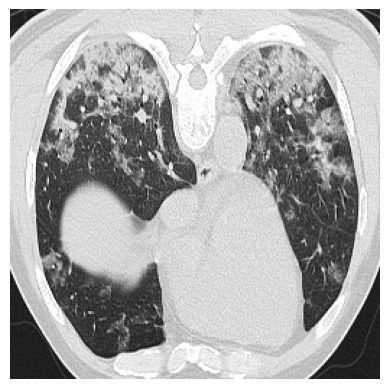

In [28]:
image = np.load("E:\\dataset\\dataset_test\\ct_scans\\coronacases_003_78.npy")
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.show()

In [3]:
model = get_model("./model.pth", "UNet")
# print(model)
image = np.load("E:\\dataset\\dataset_test\\ct_scans\\coronacases_003_78.npy")
if np.max(image) > 1.0:
    image = image / 255.0
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.type(torch.FloatTensor)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.unsqueeze(0)

if torch.cuda.is_available():
    model = model.cuda()
    image_tensor = image_tensor.cuda()
# coronacases_003_133.npy

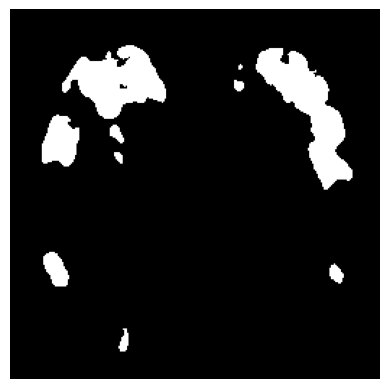

In [36]:
tmp_input = image_tensor + torch.clamp(torch.randn_like(image_tensor) * 0.1, -0.2, 0.2)
with torch.no_grad():
    pred = model(tmp_input)
pred = torch.sigmoid(pred)
pred = torch.where(pred >= 0.5, torch.ones_like(
                pred), torch.zeros_like(pred))
plt.imshow(pred[0][0].detach().cpu().numpy(), cmap='gray')
plt.axis("off")
plt.show()

In [36]:
T = 20
model.eval()
preds = torch.zeros([T, image_tensor.shape[1], image_tensor.shape[2], image_tensor.shape[3]]).cuda()
for i in range(T):
    tmp_input = image_tensor + torch.clamp(torch.randn_like(image_tensor) * 0.1, -0.2, 0.2)
    with torch.no_grad():
        preds[i] = model(tmp_input)[0]
        # preds[i] = model(image_tensor)[0]
# print(preds.size())
preds = torch.sigmoid(preds)
# print(preds.size())
preds = torch.mean(preds, dim=0)  #(batch, 2, 112,112,80)
uncertainty = -1.0*torch.sum(preds*torch.log(preds + 1e-6), dim=0, keepdim=True) #(batch, 1, 112,112,80)

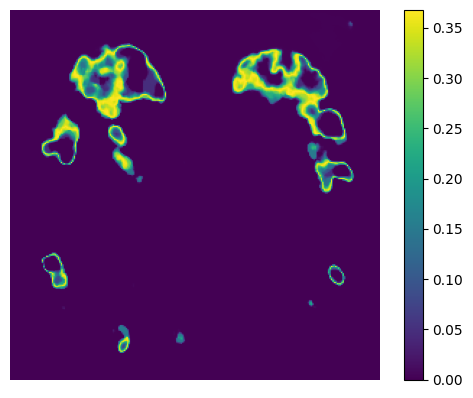

In [39]:
uncer = uncertainty[0].cpu().numpy()
# print(np.min(uncer*255))
# uncer = cv2.applyColorMap(np.uint8(255 * uncer), cv2.COLORMAP_JET)
# uncer = cv2.cvtColor(uncer, cv2.COLOR_BGR2RGB)
# uncer = np.float32(uncer) / 255

plt.imshow(uncer)
plt.colorbar()
plt.axis("off")
plt.show()